In [11]:
from functools import partial

import pennylane as qml
from pennylane import numpy as np

from pennylane.tape import QuantumTape

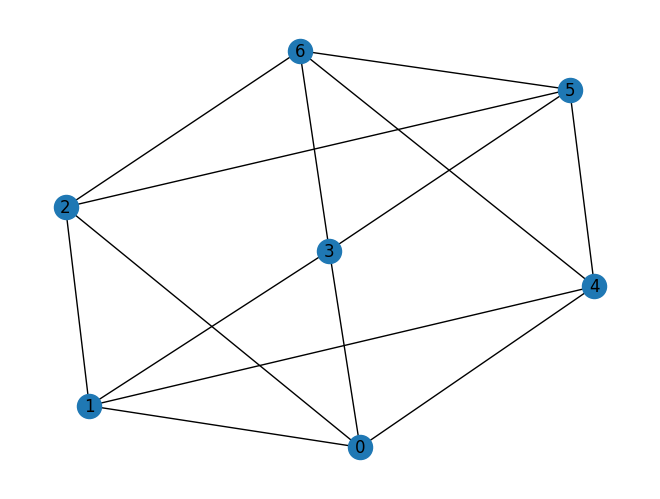

In [12]:
import networkx as nx
from itertools import product, combinations

np.random.seed(1337)

n_side_nodes = 2
n_middle_nodes = 3

top_nodes = range(0, n_side_nodes)
middle_nodes = range(n_side_nodes, n_side_nodes + n_middle_nodes)
bottom_nodes = range(n_side_nodes + n_middle_nodes, n_middle_nodes + 2 * n_side_nodes)

top_edges = list(product(top_nodes, middle_nodes))
bottom_edges = list(product(middle_nodes, bottom_nodes))

graph = nx.Graph()
graph.add_edges_from(combinations(top_nodes, 2), color=0)
graph.add_edges_from(top_edges, color=0)
graph.add_edges_from(bottom_edges, color=1)
graph.add_edges_from(combinations(bottom_nodes, 2), color=1)

nx.draw_spring(graph, with_labels=True)

In [13]:
optimal_params = np.array([-0.240, 0.327])
optimal_cost = -0.248

In [14]:
def make_kraus_ops(num_wires: int):

    d = 2**num_wires

    # High level idea: Take the identity operator on d^2 x d^2 and look at each row independently.
    # When reshaped into a matrix, it gives exactly the matrix representation of |i><j|:

    kraus0 = np.identity(d**2).reshape(d**2, d, d)

    kraus0 = np.concatenate([kraus0, np.identity(d)[None, :, :]], axis=0)
    # Add the identity op' to the mix

    kraus0 /= np.sqrt(d + 1)  # Normalize

    # Same trick for the other Kraus op'
    kraus1 = np.identity(d**2).reshape(d**2, d, d)
    kraus1 /= np.sqrt(d)

    # Finally, return a list of NumPy arrays, as per `qml.QubitChannel` docs.
    return list(kraus0.astype(complex)), list(kraus1.astype(complex))

In [15]:
def qaoa_template(params):

    gamma, beta = params

    for i in range(len(graph)):  # Apply the Hadamard gates
        qml.Hadamard(wires=i)

    for i, j in top_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # green edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    qml.WireCut(wires=middle_nodes)  # Place the wire cut

    for i, j in bottom_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # purple edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    for i in graph.nodes():  # Finally, apply the RX gates
        qml.RX(2 * beta, wires=i)

In [16]:
def qaoa_cost(bitstring):

    bitstring = np.atleast_2d(bitstring)
    # Make sure that we operate correctly on a batch of bitstrings

    z = (-1) ** bitstring[:, graph.edges()]  # Filter out pairs of bits correspondimg to graph edges
    costs = z.prod(axis=-1).sum(axis=-1)  # Do products and sums
    return np.squeeze(costs) / len(graph.edges)  # Normalize

In [17]:
all_wires = list(range(len(graph)))

with qml.queuing.AnnotatedQueue() as q:
    qaoa_template(optimal_params)
    qml.sample(wires=all_wires)

tape = QuantumTape.from_queue(q)

In [18]:
cut_index = 0
wire_cut = None

for i, op in enumerate(tape.operations):
    if isinstance(op, qml.WireCut):
        cut_index = i
        wire_cut = op
        break

k = len(wire_cut.wires)
d = 2**k

K0, K1 = make_kraus_ops(k)  # Generate Kraus operators on the fly
probs = (d + 1) / (2 * d + 1), d / (2 * d + 1)  # Probabilities of the two channels

psi_0 = qml.QubitChannel(K0, wires=wire_cut.wires)
psi_1 = qml.QubitChannel(K1, wires=wire_cut.wires)

ops_0 = tape.operations
ops_0[cut_index] = psi_0
ops_1 = tape.operations
ops_1[cut_index] = psi_1

tape0 = QuantumTape(ops=ops_0, measurements=tape.measurements)
tape1 = QuantumTape(ops=ops_1, measurements=tape.measurements)

In [19]:
n_shots = 10000

samples = np.zeros((n_shots, len(tape.wires)), dtype=int)

rng = np.random.default_rng(seed=1337)
choices = rng.choice(2, size=n_shots, p=probs)

channels, channel_shots = np.unique(choices, return_counts=True)

In [27]:
device = qml.device("default.mixed", wires=tape.wires)


device.shots = channel_shots[0].item()
(shots0,) = qml.execute([tape0], device=device, cache=False, gradient_fn=None)
samples[choices == 0] = shots0

device.shots = channel_shots[1].item()
(shots1,) = qml.execute([tape1], device=device, cache=False, gradient_fn=None)
samples[choices == 1] = shots1

In [21]:
d = 2**k

shot_counts = np.logspace(1, 4, num=20, dtype=int, requires_grad=False)
pauli_cost_values = np.zeros_like(shot_counts, dtype=float)

randomized_cost_values = np.zeros_like(pauli_cost_values)

signs = np.array([1, -1], requires_grad=False)
shot_signs = signs[choices]

for i, cutoff in enumerate(shot_counts):
    costs = qaoa_cost(samples[:cutoff])
    randomized_cost_values[i] = (2 * d + 1) * np.mean(shot_signs[:cutoff] * costs)

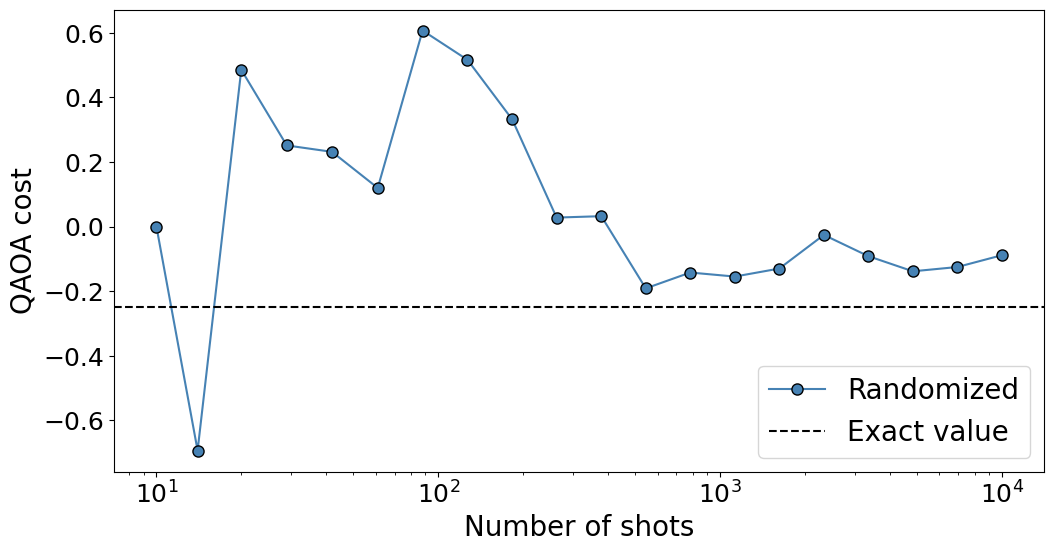

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))


ax.semilogx(
    shot_counts,
    randomized_cost_values,
    "o-",
    c="steelblue",
    ms=8,
    markeredgecolor="k",
    label="Randomized",
)

ax.axhline(optimal_cost, color="k", linestyle="--", label="Exact value")

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_ylabel("QAOA cost", fontsize=20)
ax.set_xlabel("Number of shots", fontsize=20)

_ = ax.legend(frameon=True, loc="lower right", fontsize=20)